In this notebook, I will experiment with different schedulers, seeing which can improve the standard coursework 1 setup.

In [ ]:
#Run experiments using fixed, list, newBob and exponential use different scheduler each loop

In [11]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperiments")


options = {1: 'Exponential', 2: 'Fixed', 3: 'NewBob', 4: 'List'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(0,3):
    #Go through for each learning rate
    for rate in xrange(1, 5):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)
        elif rate == 4:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            
            #Build this up instead
            lr_scheduler = LearningRateList(learningList,max_epochs=max_epochs)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting Exponential
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.570. Accuracy is 9.28%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.761. Accuracy is 85.84%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.262. Accuracy is 92.61%
INFO:mlp.schedulers:0.495024916875
INFO:mlp.optimisers:Epoch 2: Took 62 seconds. Training speed 881 pps. Validation speed 1998 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.269. Accuracy is 92.06%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.228. Accuracy is 93.41%
INFO:mlp.schedulers:0.490099336653
INFO:mlp.optimisers:Epoch 3: Took 62 seconds. Training speed 879 pps. Validation speed 1992 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.222. Accuracy is 93.56%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.

Use 50 epochs, 0.01, 0.05, 0.1, 0.2, 0.5, 
Build the list from (start_rate / epochs), to have constant decrease otherwise it would return a 0 learning rate.
Always start from 0.5
Use both 1 and 2 layers and 3 layers as interested in different schedulers affects on depth of network.
Save the exponential decline, as well as list and newBobs rate.



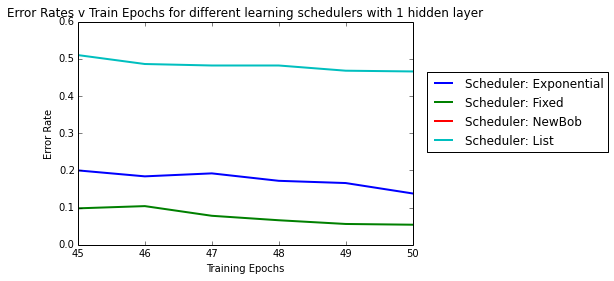

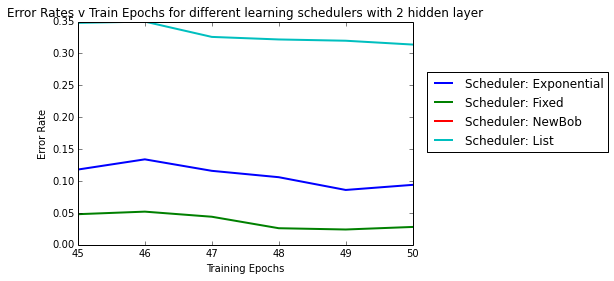

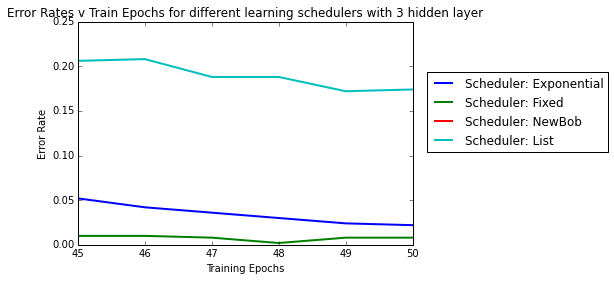

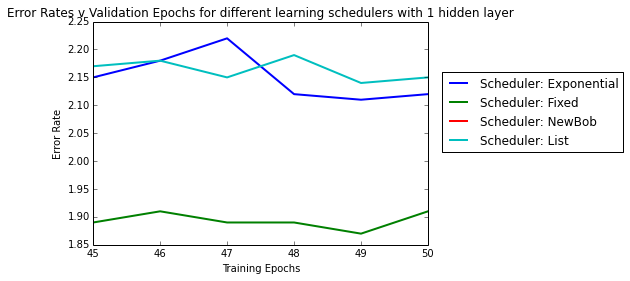

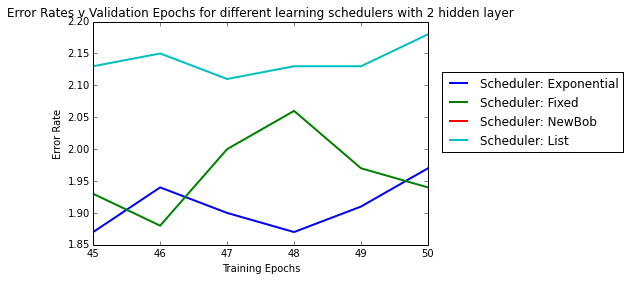

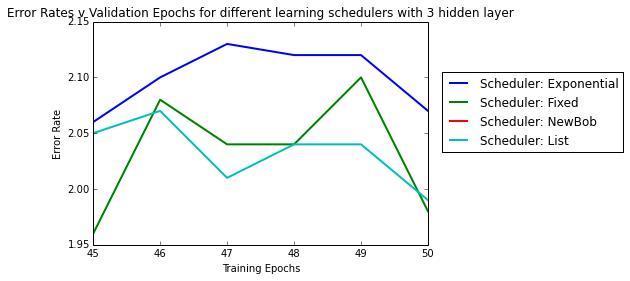

In [3]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['Exponential', 'Fixed', 'NewBob','List']

for i in xrange(0,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[45:len(shelve_p[lists+str(i)][0])], train_error[45:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(0,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[45:len(shelve_p[lists+str(i)][0])], train_error[45:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

Experiment with different newBob parameters, better with multiple layers

In [1]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew", writeback = True)


options = {1: 'NewBob100', 2: 'NewBob50', 3: 'NewBob25'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 100)
        elif rate == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 50)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 25)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))
        

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting NewBob100
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.428. Accuracy is 7.55%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.754. Accuracy is 79.81%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.277. Accuracy is 91.94%
INFO:mlp.optimisers:Epoch 2: Took 78 seconds. Training speed 704 pps. Validation speed 1438 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.288. Accuracy is 91.34%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.246. Accuracy is 92.58%
INFO:mlp.optimisers:Epoch 3: Took 86 seconds. Training speed 640 pps. Validation speed 1307 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.230. Accuracy is 93.31%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.212. Accuracy is 93.89%
INFO:mlp.optimisers:Epoch 4: Took 90 seconds. Tr

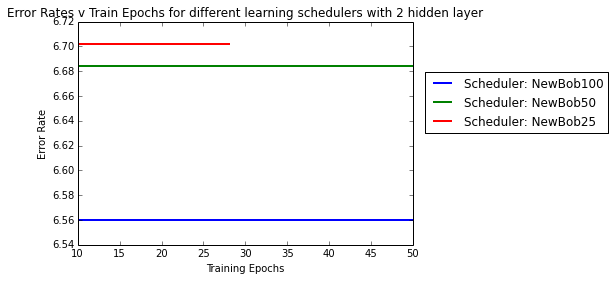

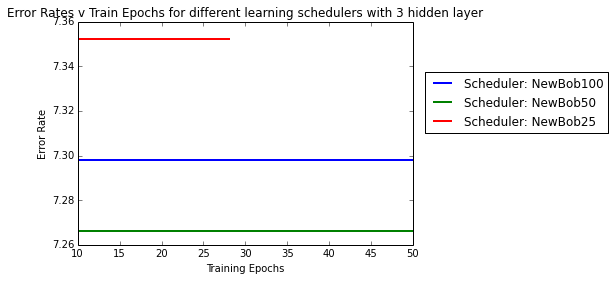

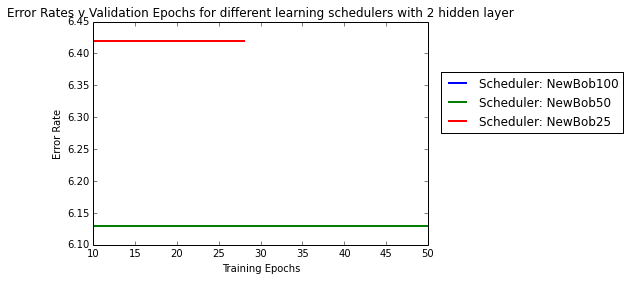

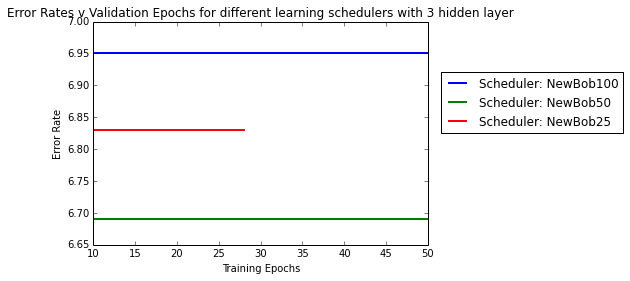

In [13]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100', 'NewBob50', 'NewBob25']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

In [7]:
import shelve
shelve_p = shelve.open("learningRateExperimentsNew")

print shelve_p['NewBob1001']

([(2.4279990388481445, 0.075539999999999885), (0.75381977951175949, 0.79812000000000005), (0.28842155166855343, 0.91336000000000062), (0.23019613859476568, 0.93310000000000037), (0.22625559994021907, 0.93439999999999923), (0.22594794779103561, 0.93440000000000034), (0.22593552415336193, 0.93440000000000112), (0.22593490800884797, 0.9343999999999999), (0.22593487710980839, 0.93440000000000067), (0.22593487556949429, 0.93440000000000001), (0.22593487549304353, 0.93439999999999968), (0.22593487548918725, 0.93439999999999945), (0.22593487548899407, 0.9344000000000009), (0.22593487548898469, 0.93440000000000056), (0.22593487548898458, 0.9343999999999999), (0.22593487548898455, 0.93440000000000001), (0.22593487548898455, 0.93439999999999968), (0.2259348754889845, 0.9343999999999999), (0.22593487548898433, 0.93440000000000012), (0.22593487548898439, 0.93440000000000045), (0.22593487548898472, 0.93439999999999934), (0.22593487548898464, 0.9344000000000009), (0.22593487548898444, 0.934400000000

NewBob - Scale by half instead of a 20th, min difference is 0.05 still

In [14]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperiments")


options = {1: 'NewBob100', 2: 'NewBob50', 3: 'NewBob25'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.5, zero_rate=learning_rate, patience = 100)
        elif rate == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.5, zero_rate=learning_rate, patience = 50)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.5, zero_rate=learning_rate, patience = 25)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+'H'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting NewBob100
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.428. Accuracy is 7.55%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.754. Accuracy is 79.81%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.277. Accuracy is 91.94%
INFO:mlp.optimisers:Epoch 2: Took 78 seconds. Training speed 703 pps. Validation speed 1484 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.288. Accuracy is 91.34%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.246. Accuracy is 92.58%
INFO:mlp.optimisers:Epoch 3: Took 77 seconds. Training speed 704 pps. Validation speed 1567 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.227. Accuracy is 93.33%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.203. Accuracy is 94.11%
INFO:mlp.optimisers:Epoch 4: Took 81 seconds. Tr

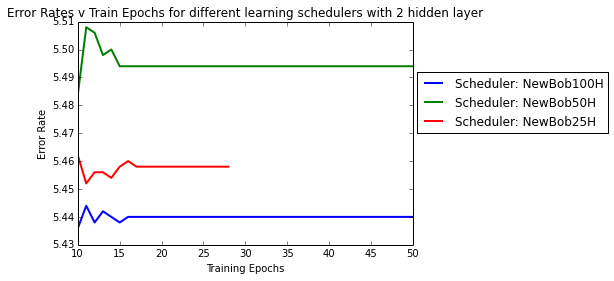

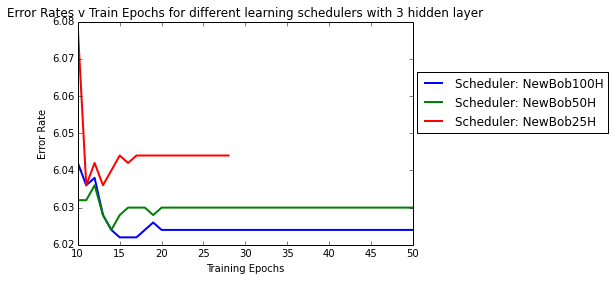

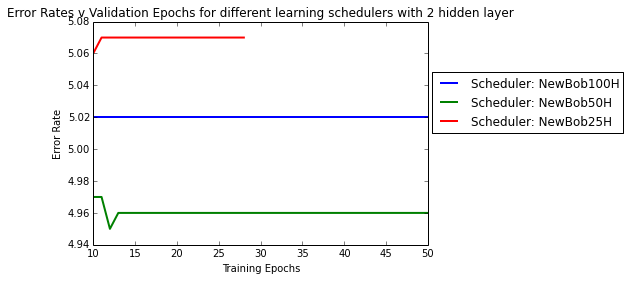

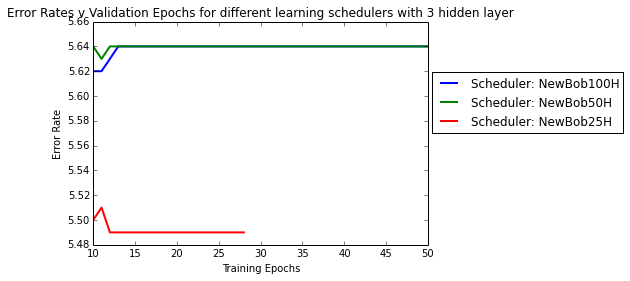

In [14]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100H', 'NewBob50H', 'NewBob25H']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

In [8]:
import shelve
shelve_p = shelve.open("learningRateExperiments")

print shelve_p['NewBob25H2']

([(2.4851677760594457, 0.11356000000000006), (0.98010187261889814, 0.68355999999999983), (0.32330146141274413, 0.90215999999999885), (0.25080930751327979, 0.92480000000000018), (0.22505224990313585, 0.9334399999999996), (0.21394516407646422, 0.9362200000000005), (0.20879510551207633, 0.93827999999999967), (0.20613844160123085, 0.93889999999999973), (0.20477735159555099, 0.93910000000000038), (0.20415755903256572, 0.93916000000000055), (0.20379402683181524, 0.93922000000000061), (0.20360995905200852, 0.93963999999999992), (0.20351600560221678, 0.93957999999999953), (0.20346956903104552, 0.93963999999999992), (0.20344604746470843, 0.93960000000000043), (0.20343427324233365, 0.93956000000000039), (0.20342835151929822, 0.93957999999999997), (0.20342539105021973, 0.93956000000000051), (0.20342390125949761, 0.93956000000000006), (0.20342313435521561, 0.93956000000000039), (0.20342276217683769, 0.93955999999999984), (0.20342257412431275, 0.93956000000000028), (0.20342248343363095, 0.939559999

Different exponential rates

In [15]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperiments")


options = {1: 'Exponential05', 2: 'Exponential06', 3: 'Exponential07'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=0.5, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateExponential(start_rate=0.6, max_epochs=max_epochs, training_size=100)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateExponential(start_rate=0.7, max_epochs=max_epochs, training_size=100)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting Exponential05
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.428. Accuracy is 7.55%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.754. Accuracy is 79.81%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.277. Accuracy is 91.94%
INFO:mlp.schedulers:0.495024916875
INFO:mlp.optimisers:Epoch 2: Took 77 seconds. Training speed 708 pps. Validation speed 1515 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.288. Accuracy is 91.35%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.246. Accuracy is 92.61%
INFO:mlp.schedulers:0.490099336653
INFO:mlp.optimisers:Epoch 3: Took 77 seconds. Training speed 706 pps. Validation speed 1527 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.231. Accuracy is 93.12%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 

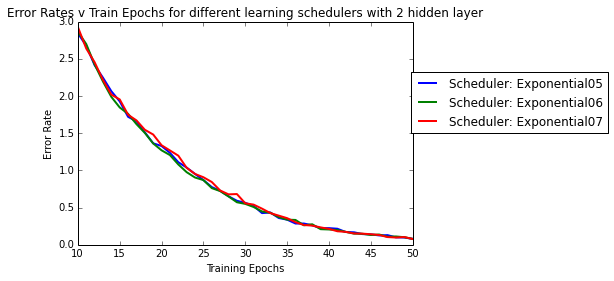

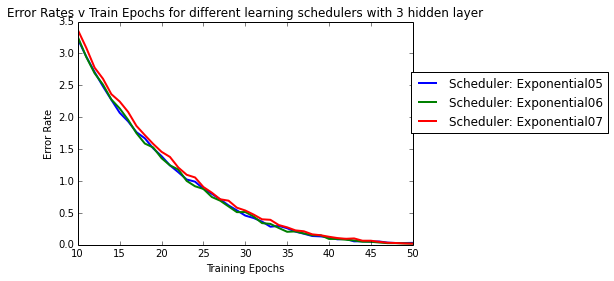

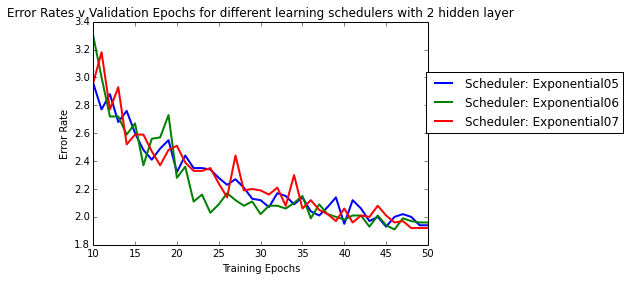

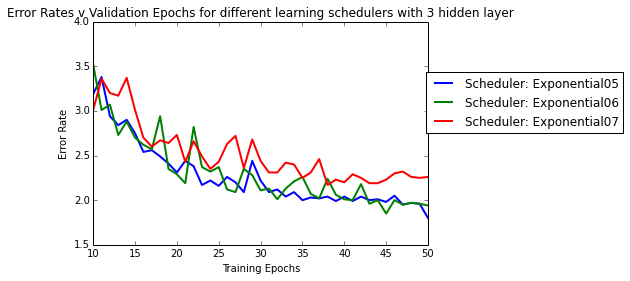

In [17]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['Exponential05', 'Exponential06', 'Exponential07']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

New Bob with half for min error and learning rate

In [2]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew", writeback = True)


options = {1: 'NewBob100', 2: 'NewBob50', 3: 'NewBob25'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.5, scale_by=0.5, zero_rate=learning_rate, patience = 100)
        elif rate == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.5, scale_by=0.5, zero_rate=learning_rate, patience = 50)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.5, scale_by=0.5, zero_rate=learning_rate, patience = 25)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+'HH'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting NewBob100
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.428. Accuracy is 7.55%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.754. Accuracy is 79.81%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.277. Accuracy is 91.94%
INFO:mlp.optimisers:Epoch 2: Took 92 seconds. Training speed 595 pps. Validation speed 1302 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.288. Accuracy is 91.34%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.246. Accuracy is 92.58%
INFO:mlp.optimisers:Epoch 3: Took 92 seconds. Training speed 596 pps. Validation speed 1309 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.227. Accuracy is 93.33%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.203. Accuracy is 94.11%
INFO:mlp.optimisers:Epoch 4: Took 90 seconds. Tr

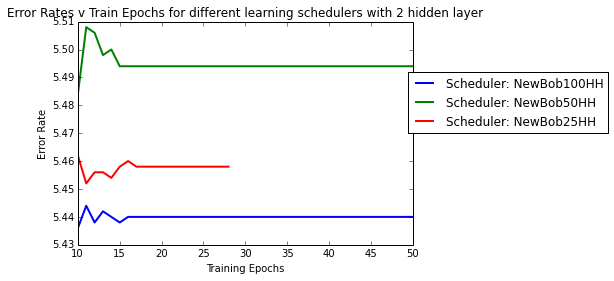

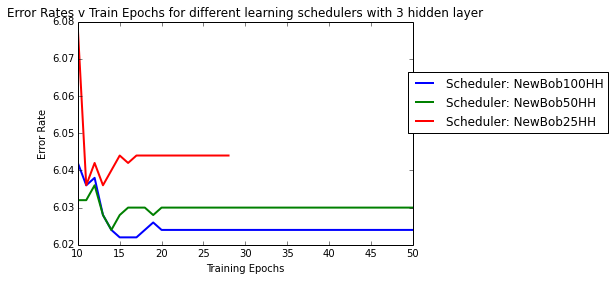

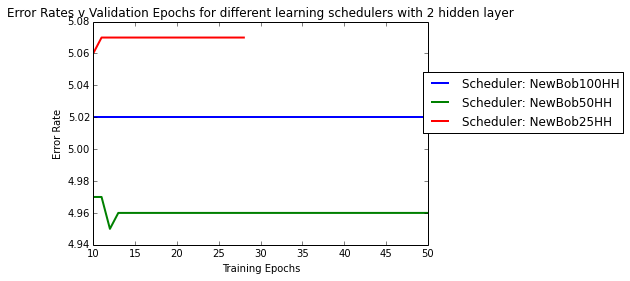

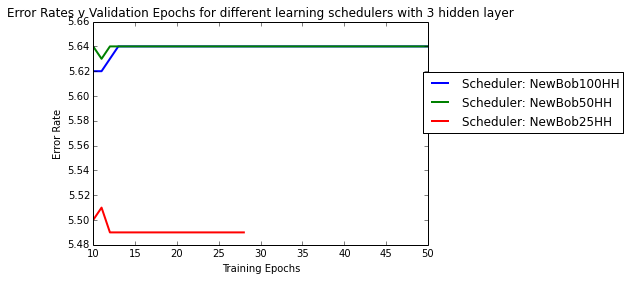

In [15]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100HH', 'NewBob50HH', 'NewBob25HH']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

NewBob experiments with 10 epochs

In [17]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperiments")


options = {1: 'NewBob10', 2: 'NewBob10'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 3):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.5, zero_rate=learning_rate, patience = 10)
        elif rate == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.5, scale_by=0.5, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        if rate == 1:
            shelve_p[options[rate]+'H'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))
        if rate == 2:
            shelve_p[options[rate]+'HH'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))
            
logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting NewBob10
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.428. Accuracy is 7.55%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.754. Accuracy is 79.81%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.277. Accuracy is 91.94%
INFO:mlp.optimisers:Epoch 2: Took 76 seconds. Training speed 716 pps. Validation speed 1519 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.288. Accuracy is 91.34%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.246. Accuracy is 92.58%
INFO:mlp.optimisers:Epoch 3: Took 76 seconds. Training speed 717 pps. Validation speed 1503 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.227. Accuracy is 93.33%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.203. Accuracy is 94.11%
INFO:mlp.optimisers:Epoch 4: Took 76 seconds. Tra

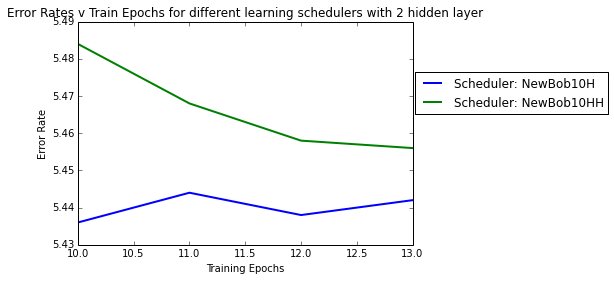

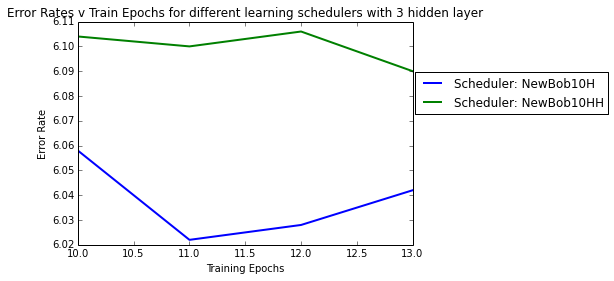

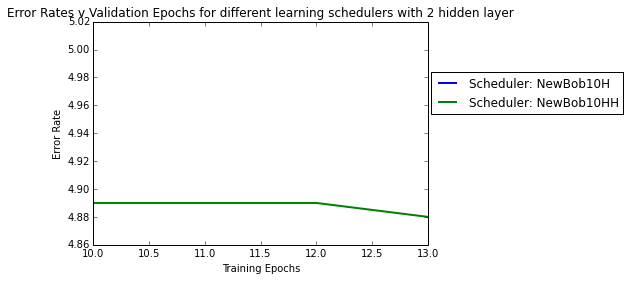

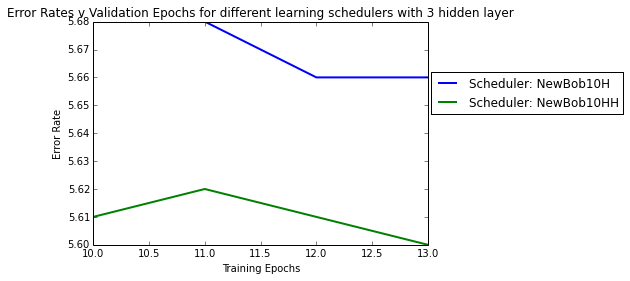

In [16]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob10H', 'NewBob10HH']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()